# New Clue
In this notebook, we'll test the new, simplified CLUE implementation. We're not using Bayesian Neural Networks here, so the uncertainty is just the entropy of the classifier.

## Setup


Import libraries

In [2]:
import importlib
import regene_models
importlib.reload(regene_models)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import new_CLUE
importlib.reload(new_CLUE)

<module 'new_CLUE' from '/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/new_CLUE.py'>

Set the device

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


Load the Datasets

In [4]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

Set the latent dimension

In [5]:
latent_dim = 256

Create a models directory if it doesn't exist

In [6]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

## Load models

In [ ]:
from mnist_classifier import MNISTClassifier
from mnist_vae import VAE

classifier = MNISTClassifier(device=device)
vae = VAE(latent_dim=latent_dim, device=device)

classifier.load_state_dict(torch.load('models/mnist_classifier.pth', map_location=device))
vae.load_state_dict(torch.load('models/mnist_vae.pth', map_location=device))

classifier.eval()
vae.eval()

/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_53464/3981658417.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load('models

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=256, bias=True)
  )
  (fc_mu): Linear(in_features=256, out_features=256, bias=True)
  (fc_var): Linear(in_features=256, out_features=256, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=6272, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(128, 7, 7))
    (3): ConvTranspose2d(128, 64, kernel_size=

## Get most uncertain images

In [12]:
# Create a non-shuffled loader for uncertainty calculation
eval_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False, num_workers=2)

# Get uncertainty scores for all training data points
uncertainties = []
indices = []

classifier.eval()
with torch.no_grad():
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        # Get latent representations and predictions
        logits = classifier(images)
        
        # Calculate uncertainty (entropy) for each prediction
        probs = torch.nn.functional.softmax(logits, dim=1)
        entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
        
        # Store uncertainties and indices
        uncertainties.extend(entropy.cpu().numpy())
        indices.extend(range(i*eval_loader.batch_size, min((i+1)*eval_loader.batch_size, len(trainset))))

# Convert to numpy arrays
uncertainties = np.array(uncertainties)
indices = np.array(indices)

# Sort by uncertainty (descending order)
sorted_idx = np.argsort(-uncertainties)
sorted_uncertainties = uncertainties[sorted_idx]
sorted_data_indices = indices[sorted_idx]

# Verify the most uncertain predictions
print("\nVerifying top 5 most uncertain predictions:")
classifier.eval()
with torch.no_grad():
    for i in range(5):
        idx = sorted_data_indices[i]
        image, _ = trainset[idx]
        image = image.to(device).unsqueeze(0)
        logits = classifier(image)
        probs = torch.nn.functional.softmax(logits, dim=1)
        entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
        print(f"\nPrediction {i+1}:")
        print(f"Stored entropy: {sorted_uncertainties[i]:.3f}")
        print(f"Recalculated entropy: {entropy.item():.3f}")
        print(f"Probabilities: {probs[0].cpu().numpy().round(3)}")

print(f"\nMost uncertain predictions have entropy: {sorted_uncertainties[:5]}")
print(f"Least uncertain predictions have entropy: {sorted_uncertainties[-5:]}")


Verifying top 5 most uncertain predictions:

Prediction 1:
Stored entropy: 1.477
Recalculated entropy: 1.477
Probabilities: [0.001 0.159 0.    0.081 0.08  0.042 0.021 0.008 0.538 0.068]

Prediction 2:
Stored entropy: 1.468
Recalculated entropy: 1.468
Probabilities: [0.    0.324 0.001 0.    0.312 0.    0.    0.081 0.197 0.085]

Prediction 3:
Stored entropy: 1.440
Recalculated entropy: 1.440
Probabilities: [0.295 0.    0.369 0.091 0.001 0.002 0.044 0.    0.195 0.004]

Prediction 4:
Stored entropy: 1.411
Recalculated entropy: 1.411
Probabilities: [0.001 0.025 0.002 0.305 0.088 0.087 0.009 0.001 0.452 0.03 ]

Prediction 5:
Stored entropy: 1.393
Recalculated entropy: 1.393
Probabilities: [0.523 0.257 0.016 0.026 0.005 0.    0.082 0.03  0.019 0.041]

Most uncertain predictions have entropy: [1.4774847 1.4680017 1.4400232 1.4108462 1.3928013]
Least uncertain predictions have entropy: [4.3572605e-13 4.2375660e-13 3.2597959e-13 2.2302673e-13 2.1186973e-13]


In [13]:
import matplotlib.pyplot as plt
import torch

def plot_most_uncertain(trainset, sorted_data_indices, sorted_uncertainties, n_plot=5):
    """
    Plots the top-n most uncertain predictions from the training set.

    Args:
        trainset (torch.utils.data.Dataset): Dataset that returns (image, label) samples.
        sorted_data_indices (np.ndarray): Array of indices sorted in descending order by uncertainty.
        sorted_uncertainties (np.ndarray): Array of uncertainty (entropy) values, sorted to match sorted_data_indices.
        n_plot (int): Number of images to plot.
    """
    # Calculate number of rows needed
    images_per_row = 10
    n_rows = (n_plot - 1) // images_per_row + 1
    
    plt.figure(figsize=(15, 3 * n_rows))
    for i in range(n_plot):
        data_idx = sorted_data_indices[i]
        image, _ = trainset[data_idx]
        
        # If image is a torch.Tensor, convert it to a NumPy array.
        if torch.is_tensor(image):
            image = image.cpu().detach().numpy()
            # If the image has one channel [1, H, W], squeeze out the channel dimension.
            if image.ndim == 3 and image.shape[0] == 1:
                image = image.squeeze(0)
        
        row = i // images_per_row
        col = i % images_per_row
        plt.subplot(n_rows, images_per_row, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Entropy: {sorted_uncertainties[i]:.2f}")
        plt.axis("off")
    
    plt.suptitle("Most Uncertain Predictions")
    plt.show()

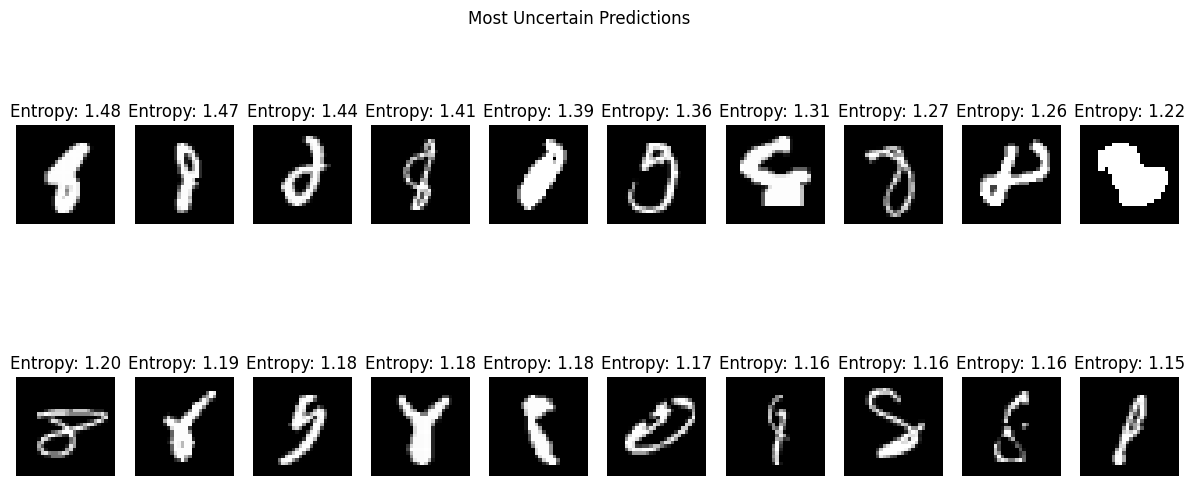

In [14]:
# Plot the most uncertain predictions
plot_most_uncertain(trainset, sorted_data_indices, sorted_uncertainties, n_plot=20)

## Test new CLUE implementation

Step 00: Loss: 0.4092, Entropy: 0.4092, Distance: 0.0000
Step 01: Loss: 0.1795, Entropy: 0.0195, Distance: 1.6000
Step 02: Loss: 0.2158, Entropy: 0.0089, Distance: 2.0693
Step 03: Loss: 0.2284, Entropy: 0.0071, Distance: 2.2127
Step 04: Loss: 0.2264, Entropy: 0.0072, Distance: 2.1924
Step 05: Loss: 0.2156, Entropy: 0.0078, Distance: 2.0774
Step 06: Loss: 0.2003, Entropy: 0.0087, Distance: 1.9161
Step 07: Loss: 0.1852, Entropy: 0.0095, Distance: 1.7575
Step 08: Loss: 0.1737, Entropy: 0.0095, Distance: 1.6414
Step 09: Loss: 0.1674, Entropy: 0.0093, Distance: 1.5815
Step 10: Loss: 0.1648, Entropy: 0.0087, Distance: 1.5607
Step 11: Loss: 0.1634, Entropy: 0.0079, Distance: 1.5546
Step 12: Loss: 0.1623, Entropy: 0.0071, Distance: 1.5521
Step 13: Loss: 0.1616, Entropy: 0.0065, Distance: 1.5511
Step 14: Loss: 0.1608, Entropy: 0.0059, Distance: 1.5488
Step 15: Loss: 0.1593, Entropy: 0.0055, Distance: 1.5382
Step 16: Loss: 0.1562, Entropy: 0.0051, Distance: 1.5113
Step 17: Loss: 0.1515, Entropy:

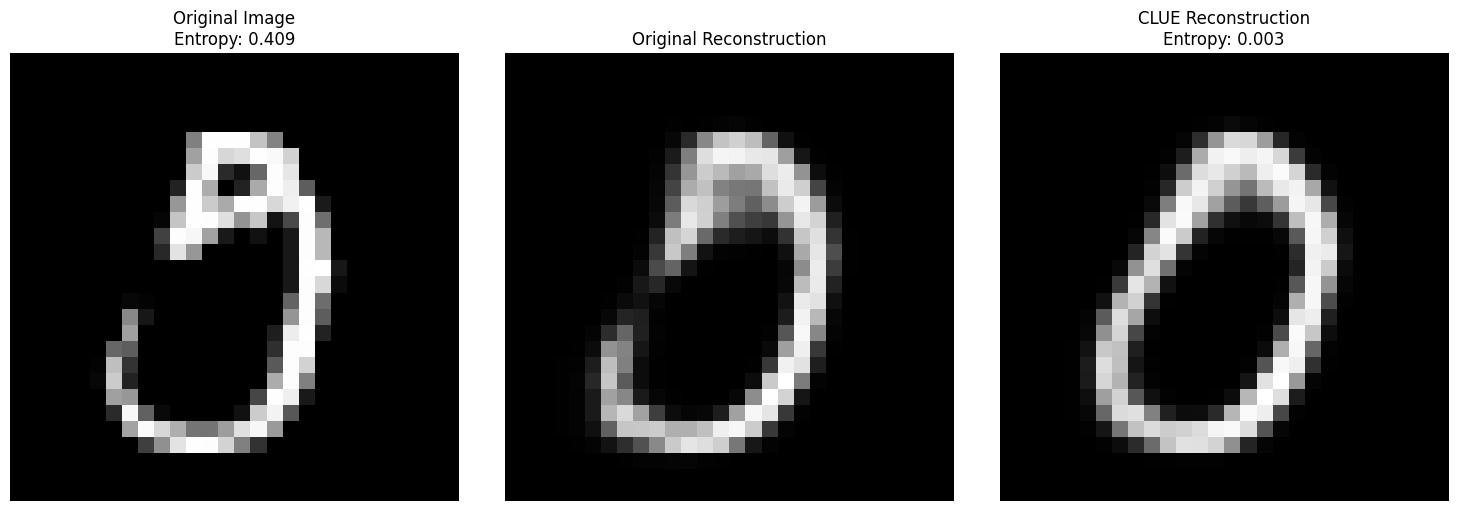


Class probabilities:
Original: [0.911 0.003 0.    0.035 0.    0.003 0.    0.01  0.    0.038]
Explained: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [25]:
import importlib
import simple_base_clue
importlib.reload(simple_base_clue)
from simple_base_clue import SimpleBaseCLUE

# Get the most uncertain image and its latent representation
most_uncertain_idx = sorted_data_indices[5]
uncertain_image, _ = trainset[most_uncertain_idx]
uncertain_image = uncertain_image.to(device).unsqueeze(0)  # Add batch dimension

# Get its latent representation
classifier.eval()
vae.eval()
with torch.no_grad():
    z0, _ = vae.encode(uncertain_image)

# Initialize CLUE
clue = SimpleBaseCLUE(
    vae=vae,
    classifier=classifier,
    z0=z0,
    uncertainty_weight=1.0,
    distance_weight=0.1,
    lr=0.1,
    device=device
)

# Optimize to find explanation
z_explained = clue.optimize(steps=20)

# Generate reconstructions using decoder
with torch.no_grad():
    # Original reconstruction
    original_recon = vae.decode(z0)
    # CLUE reconstruction  
    clue_recon = vae.decode(z_explained)
    
    # Get predictions and uncertainties
    original_logits = classifier(original_recon)
    explained_logits = classifier(clue_recon)
    
    original_probs = torch.nn.functional.softmax(original_logits, dim=1)
    explained_probs = torch.nn.functional.softmax(explained_logits, dim=1)
    
    original_entropy = -(original_probs * torch.log(original_probs + 1e-10)).sum()
    explained_entropy = -(explained_probs * torch.log(explained_probs + 1e-10)).sum()

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
plt.title(f'Original Image\nEntropy: {original_entropy:.3f}')
plt.axis('off')

plt.subplot(132)
plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
plt.title('Original Reconstruction')
plt.axis('off')

plt.subplot(133)
plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'CLUE Reconstruction\nEntropy: {explained_entropy:.3f}')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print probabilities
print("\nClass probabilities:")
print("Original:", original_probs.cpu().numpy()[0].round(3))
print("Explained:", explained_probs.cpu().numpy()[0].round(3))

Multiple CLUEs

Step 00: Loss: 1.7053, Entropy: 1.7053, Distance: 0.0000
Step 01: Loss: 2.0736, Entropy: 1.2736, Distance: 1.6000
Step 02: Loss: 1.4867, Entropy: 1.0394, Distance: 0.8947
Step 03: Loss: 1.1070, Entropy: 0.6219, Distance: 0.9701
Step 04: Loss: 1.0650, Entropy: 0.3830, Distance: 1.3639
Step 05: Loss: 0.9722, Entropy: 0.2373, Distance: 1.4698
Step 06: Loss: 0.8512, Entropy: 0.1360, Distance: 1.4304
Step 07: Loss: 0.7799, Entropy: 0.0820, Distance: 1.3957
Step 08: Loss: 0.7676, Entropy: 0.0548, Distance: 1.4257
Step 09: Loss: 0.7834, Entropy: 0.0393, Distance: 1.4881
Step 10: Loss: 0.7912, Entropy: 0.0277, Distance: 1.5270
Step 11: Loss: 0.7799, Entropy: 0.0197, Distance: 1.5204
Step 12: Loss: 0.7543, Entropy: 0.0149, Distance: 1.4788
Step 13: Loss: 0.7250, Entropy: 0.0128, Distance: 1.4244
Step 14: Loss: 0.6985, Entropy: 0.0121, Distance: 1.3730
Step 15: Loss: 0.6775, Entropy: 0.0123, Distance: 1.3303
Step 16: Loss: 0.6613, Entropy: 0.0136, Distance: 1.2956
Step 17: Loss: 0.6488, Entropy:

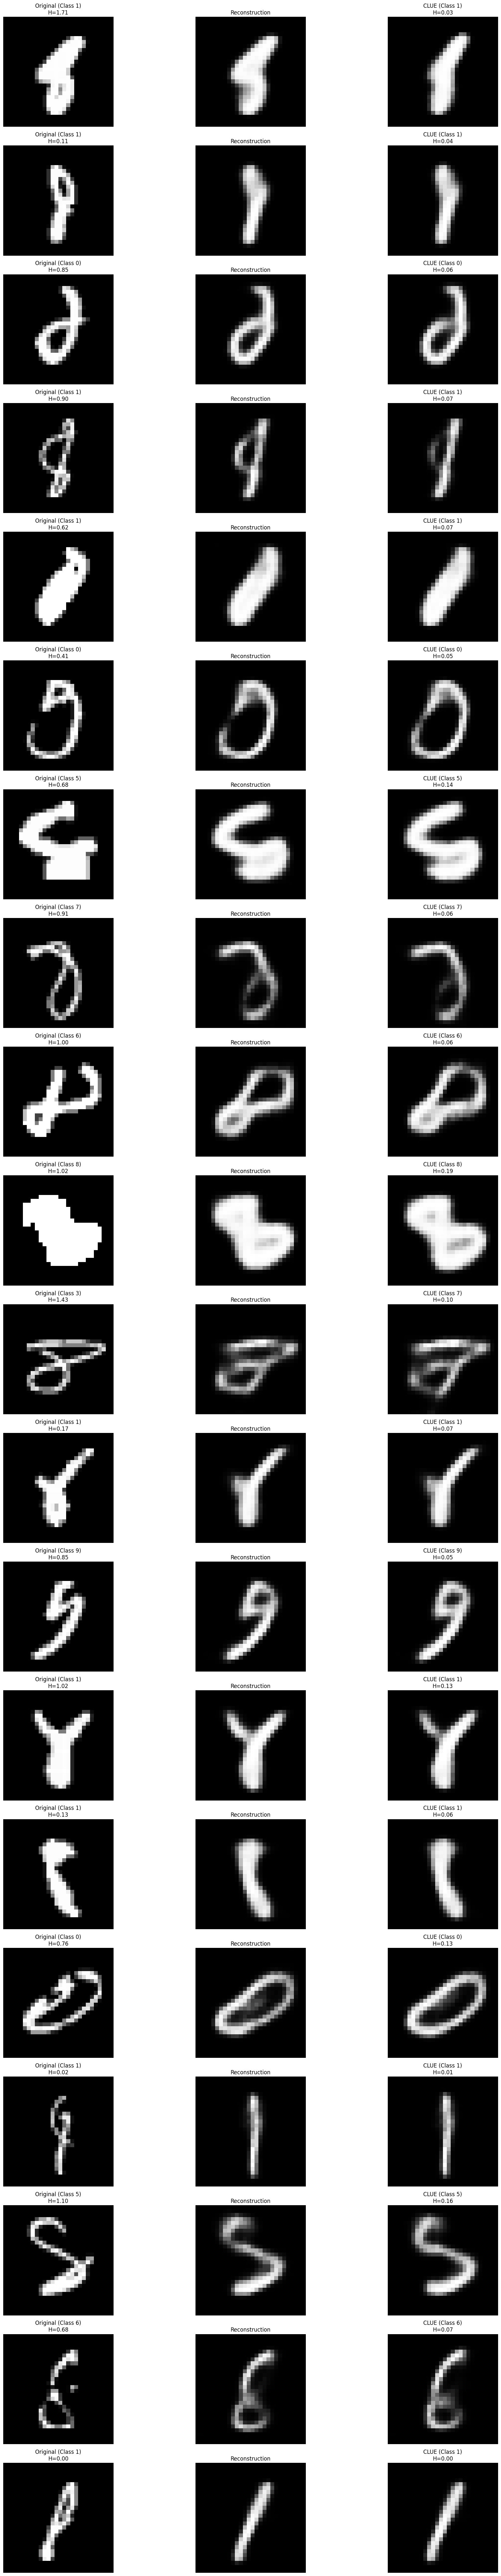


Class probabilities for last example:
Original (Class 1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Explained (Class 1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [28]:
# Import and reload modules
import importlib
import simple_base_clue
importlib.reload(simple_base_clue)
from simple_base_clue import SimpleCLUE

# Get 20 most uncertain images and generate CLUEs for each
plt.figure(figsize=(20, 80))  # Increased height significantly to give more space per row

for i in range(20):
    # Get uncertain image and its latent representation
    uncertain_idx = sorted_data_indices[i]
    uncertain_image, _ = trainset[uncertain_idx]
    uncertain_image = uncertain_image.to(device).unsqueeze(0)

    # Get latent representation
    classifier.eval()
    vae.eval()
    with torch.no_grad():
        z0, _ = vae.encode(uncertain_image)

    # Initialize and run CLUE
    clue = SimpleCLUE(
        vae=vae,
        classifier=classifier,
        z0=z0,
        uncertainty_weight=1.0,
        distance_weight=0.5,
        lr=0.1,
        device=device
    )
    z_explained = clue.optimize(steps=20)

    # Generate reconstructions
    with torch.no_grad():
        original_recon = vae.decode(z0)
        clue_recon = vae.decode(z_explained)
        
        # Get predictions and uncertainties
        original_logits = classifier(original_recon)
        explained_logits = classifier(clue_recon)
        original_probs = torch.nn.functional.softmax(original_logits, dim=1)
        explained_probs = torch.nn.functional.softmax(explained_logits, dim=1)
        original_entropy = -(original_probs * torch.log(original_probs + 1e-10)).sum()
        explained_entropy = -(explained_probs * torch.log(explained_probs + 1e-10)).sum()
        
        # Get predicted classes
        original_class = torch.argmax(original_probs).item()
        explained_class = torch.argmax(explained_probs).item()

    # Plot this example
    plt.subplot(20, 3, 3*i+1)
    plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
    plt.title(f'Original (Class {original_class})\nH={original_entropy:.2f}', fontsize=12)
    plt.axis('off')

    plt.subplot(20, 3, 3*i+2)
    plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
    plt.title('Reconstruction', fontsize=12)
    plt.axis('off')

    plt.subplot(20, 3, 3*i+3)
    plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
    plt.title(f'CLUE (Class {explained_class})\nH={explained_entropy:.2f}', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print probabilities for last example
print("\nClass probabilities for last example:")
print("Original (Class {}):".format(original_class), original_probs.cpu().numpy()[0].round(3))
print("Explained (Class {}):".format(explained_class), explained_probs.cpu().numpy()[0].round(3))